<a href="https://colab.research.google.com/github/Ismatulsyantik/FORCASTING-XGBOOST-PERCIPATION/blob/main/xg_boost_FORCASTING_FOR_TEMPMEAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# **LOAD DATASET**

In [ ]:
df = pd.read_csv("/content/weather_dataset_kota_lengkap.csv")


In [ ]:
df.columns = [col.replace("_", "").lower().strip() for col in df.columns]

df.columns

Index(['date', 'debiltcloudcover', 'debiltwindspeed', 'debiltwindgust',
       'debilthumidity', 'debiltpressure', 'debiltglobalradiation',
       'debiltprecipitation', 'debiltsunshine', 'debilttempmean',
       'debilttempmin', 'debilttempmax', 'dusseldorfcloudcover',
       'dusseldorfwindspeed', 'dusseldorfwindgust', 'dusseldorfhumidity',
       'dusseldorfpressure', 'dusseldorfglobalradiation',
       'dusseldorfprecipitation', 'dusseldorfsunshine', 'dusseldorftempmean',
       'dusseldorftempmin', 'dusseldorftempmax', 'maastrichtcloudcover',
       'maastrichtwindspeed', 'maastrichtwindgust', 'maastrichthumidity',
       'maastrichtpressure', 'maastrichtglobalradiation',
       'maastrichtprecipitation', 'maastrichtsunshine', 'maastrichttempmean',
       'maastrichttempmin', 'maastrichttempmax', 'muenchencloudcover',
       'muenchenwindspeed', 'muenchenwindgust', 'muenchenhumidity',
       'muenchenpressure', 'muenchenglobalradiation', 'muenchenprecipitation',
       'muenchensu

# WE only use 4 town to doing weather prediction

In [ ]:
kota_list = ['dusseldorf', 'maastricht', 'muenchen', 'oslo']
features = [
    'cloudcover', 'windspeed', 'windgust', 'humidity', 'pressure', 'globalradiation',
    'precipitation', 'sunshine', 'tempmean', 'tempmin', 'tempmax'
]

# **REMOVE OUTLIERS **

In [ ]:
df_outlier = df.copy()
def detect_outlier_bounds(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def remove_outliers(df, col):
    lower, upper = detect_outlier_bounds(df, col)
    return df[(df[col] >= lower) & (df[col] <= upper)]

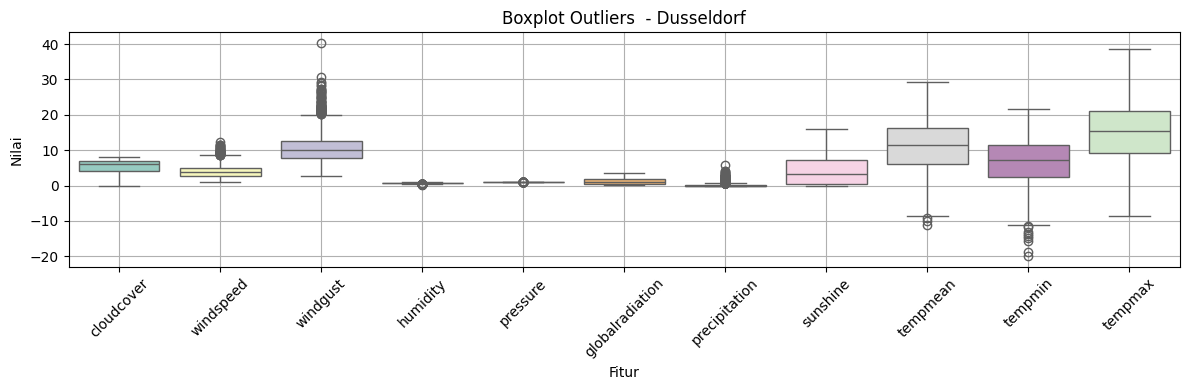

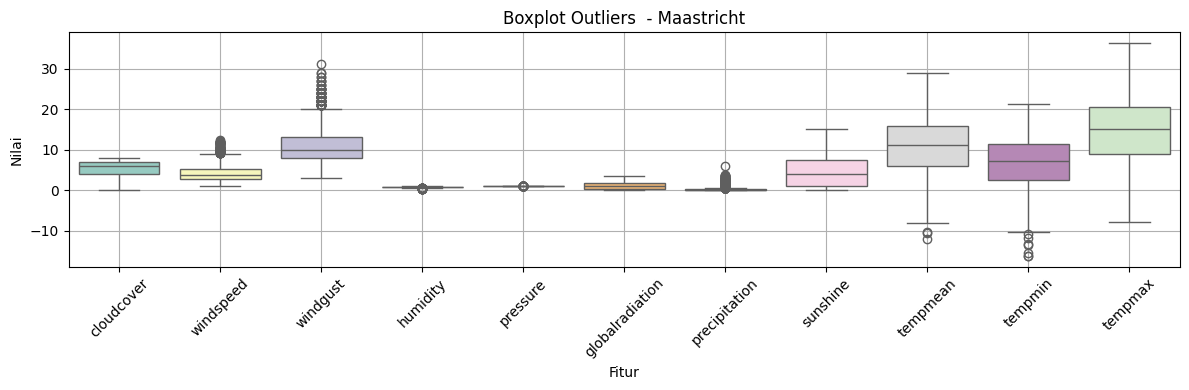

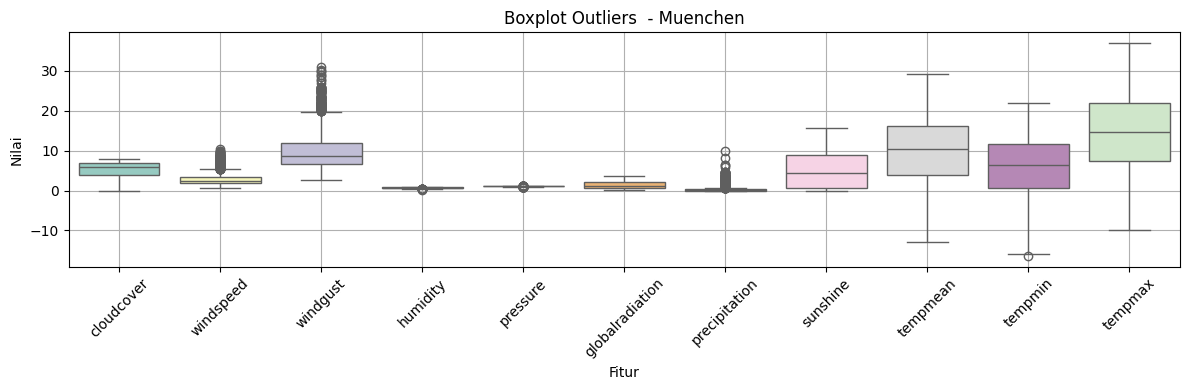

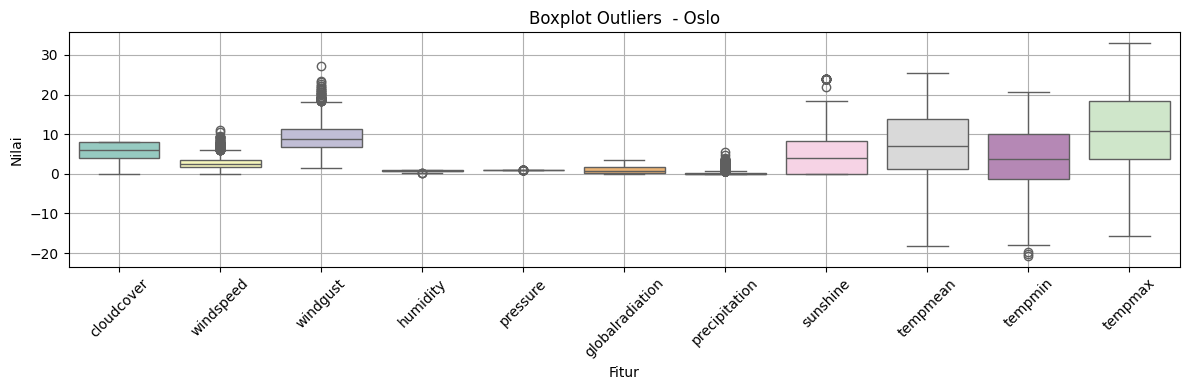

In [ ]:
for kota in kota_list:
    kota_cols = [f"{kota}{feature}" for feature in features if f"{kota}{feature}" in df_outlier.columns]

    df_kota = df_outlier[kota_cols].copy()
    df_kota.columns = features
    df_melt = df_kota.melt(var_name="Fitur", value_name="Nilai")

    plt.figure(figsize=(12, 4))
    sns.boxplot(x="Fitur", y="Nilai", hue="Fitur", data=df_melt, palette="Set3", legend=False)
    plt.title(f"Boxplot Outliers  - {kota.capitalize()}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

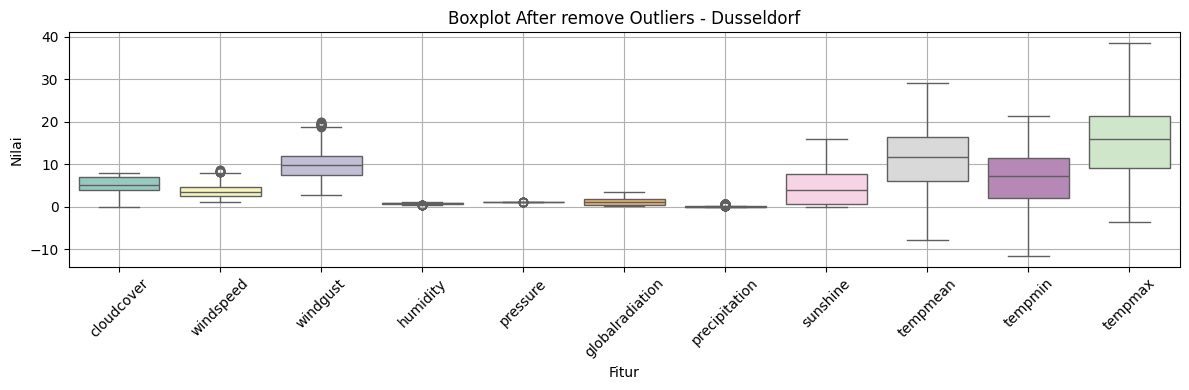

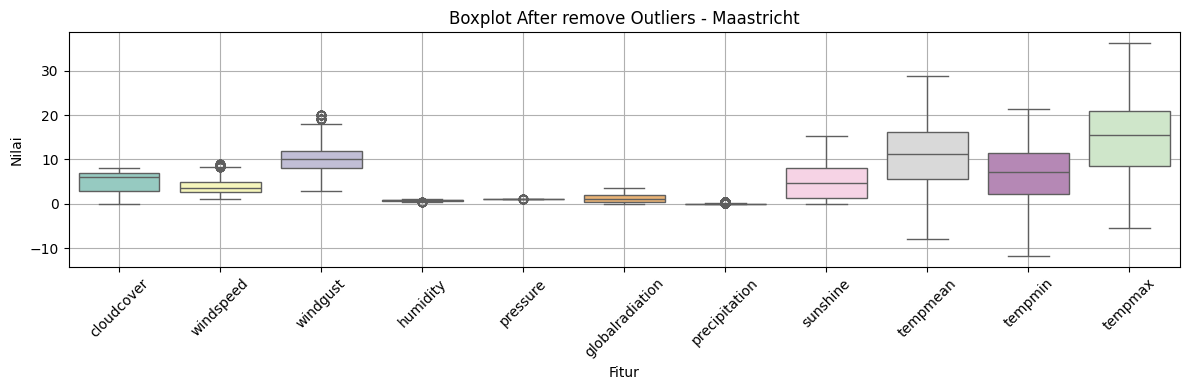

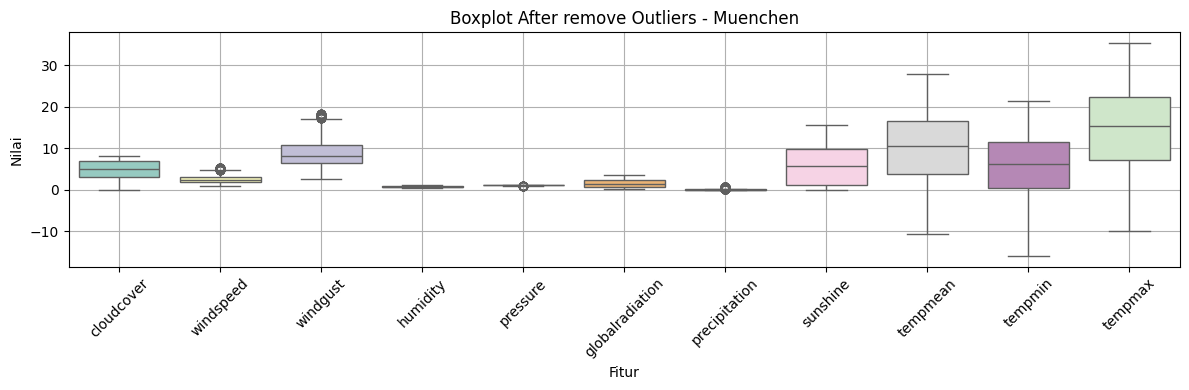

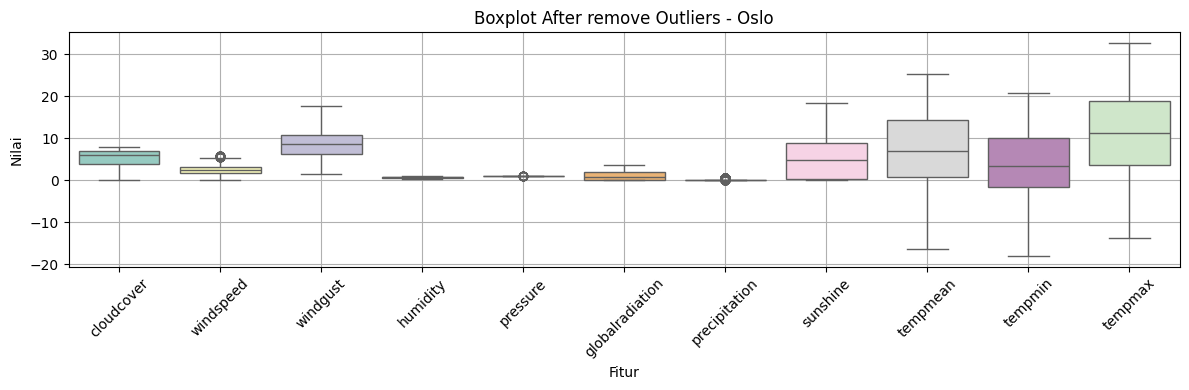

In [ ]:
for kota in kota_list:
    kota_cols = [f"{kota}{feature}" for feature in features if f"{kota}{feature}" in df_outlier.columns]

    df_kota = df_outlier[kota_cols].copy()
    df_kota.columns = features


    for col in features:
        df_kota = remove_outliers(df_kota, col)

    df_melt = df_kota.melt(var_name="Fitur", value_name="Nilai")

    plt.figure(figsize=(12, 4))
    sns.boxplot(x="Fitur", y="Nilai", hue="Fitur", data=df_melt, palette="Set3", legend=False)
    plt.title(f"Boxplot After remove Outliers - {kota.capitalize()}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()


# **STANDARiZE THE DATA**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# **CORELATTION BETWEEN THE FITUR**

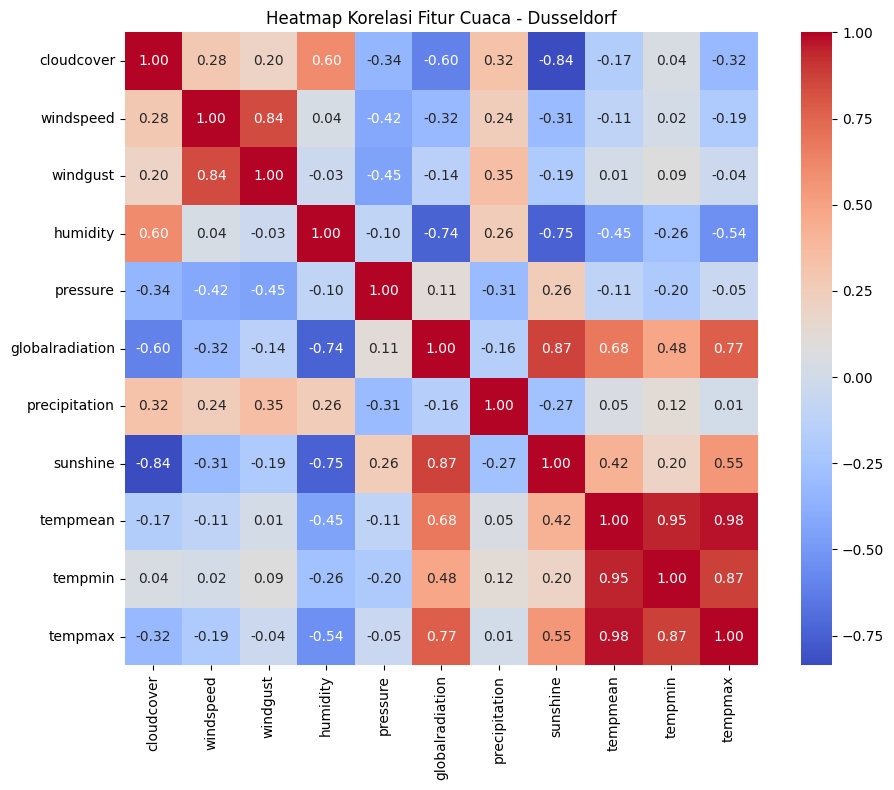

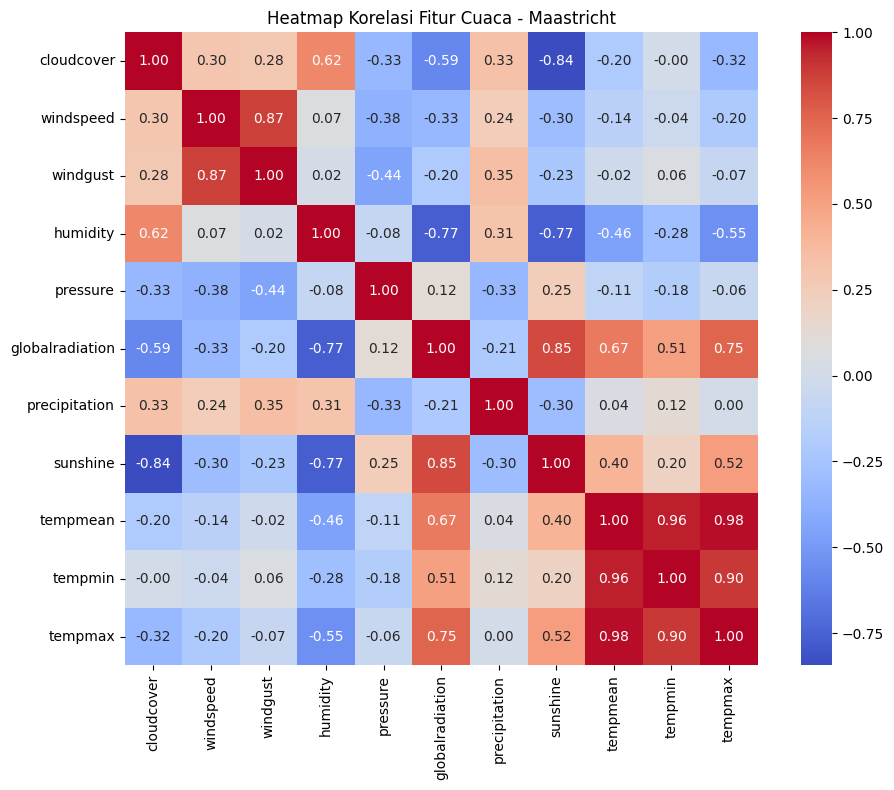

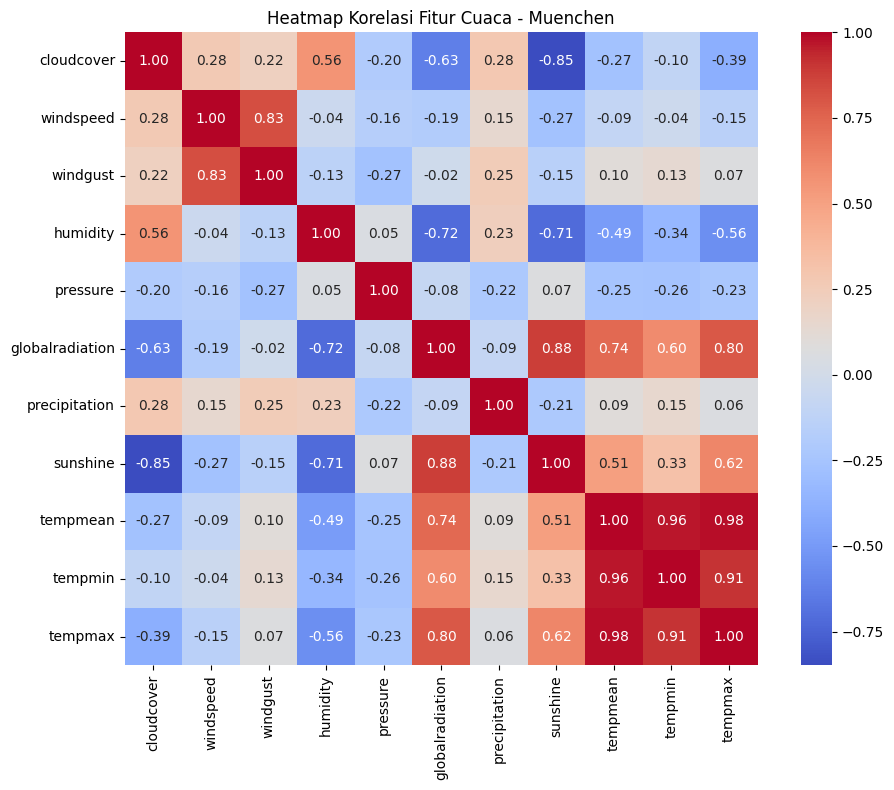

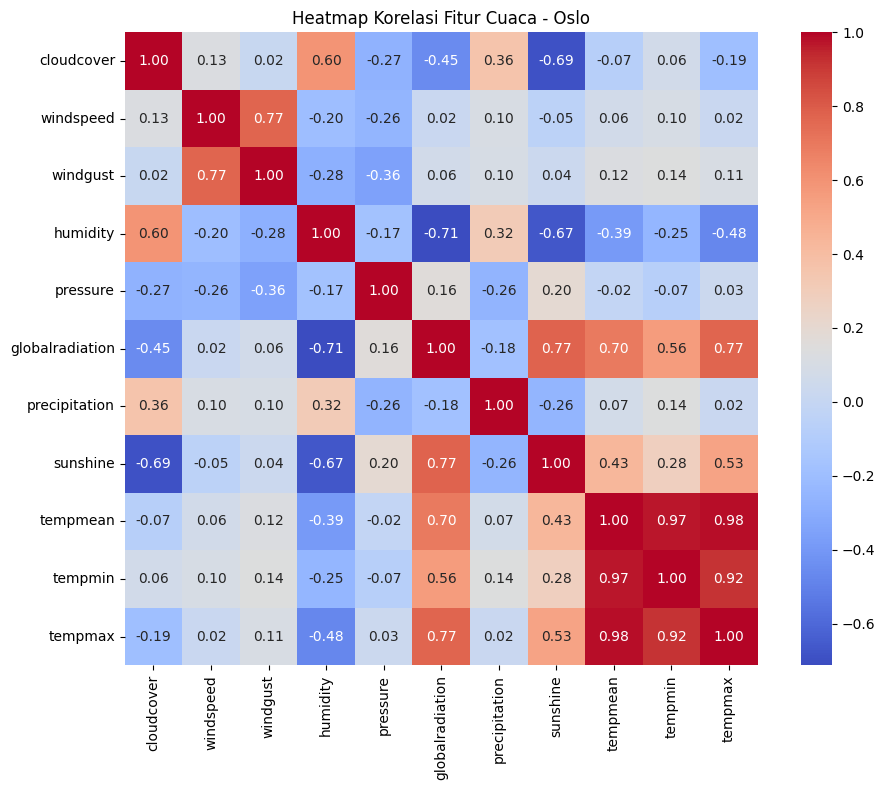

In [ ]:
kolom_fitur_kota = [f"{kota}{fitur}" for fitur in features if f"{kota}{fitur}" in df.columns]

for kota in kota_list:
    kota_cols = [col for col in df.columns if col.startswith(kota)]
    kota_cols = sorted(
        kota_cols,
        key=lambda x: features.index(x.replace(kota, "")) if x.replace(kota, "") in features else 99
    )
    renamed_cols = {f"{kota}{feat}": feat for feat in features if f"{kota}{feat}" in kota_cols}

    if not renamed_cols:
        continue
    df_kota = df[list(renamed_cols.keys())].rename(columns=renamed_cols)
    corr = df_kota.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title(f"Heatmap Korelasi Fitur Cuaca - {kota.capitalize()}")
    plt.tight_layout()
    plt.show()


# **CREATE LAGS**

In [ ]:
def create_lags(df, features, lag_days=7):
    for lag in range(1, lag_days + 1):
        for f in features:
            df[f'{f}_lag{lag}'] = df[f].shift(lag)
    return df

In [ ]:
models = {}
predictions = {}

# **MODDELING AND EVALUATION**

In [ ]:
for kota in kota_list:
    print(f'\nProcessing city: {kota}')

    kota_cols = [kota + f for f in features]
    df_kota = df[['date'] + kota_cols].copy()
    df_kota.columns = ['date'] + features
    df_kota = df_kota.sort_values('date').reset_index(drop=True)

    df_kota = create_lags(df_kota, features, lag_days=7)

    for day_ahead in range(1, 8):
        df_kota[f'tempmean_day{day_ahead}'] = df_kota['tempmean'].shift(-day_ahead)

    df_kota = df_kota.dropna().reset_index(drop=True)
    feature_cols = [col for col in df_kota.columns if 'lag' in col]

    for day_ahead in range(1, 8):
        X = df_kota[feature_cols]
        y = df_kota[f'tempmean_day{day_ahead}']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        models[(kota, day_ahead)] = model
        predictions[(kota, day_ahead)] = (y_test.index, y_pred)

        print(f'  Day +{day_ahead} forecast: MSE={mse:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}')



Processing city: dusseldorf
  Day +1 forecast: MSE=9.1084, RMSE=3.0180, R2=0.7931
  Day +2 forecast: MSE=10.7277, RMSE=3.2753, R2=0.7565
  Day +3 forecast: MSE=12.0703, RMSE=3.4742, R2=0.7261
  Day +4 forecast: MSE=12.4692, RMSE=3.5312, R2=0.7168
  Day +5 forecast: MSE=13.3925, RMSE=3.6596, R2=0.6947
  Day +6 forecast: MSE=13.1543, RMSE=3.6269, R2=0.7002
  Day +7 forecast: MSE=13.2937, RMSE=3.6461, R2=0.6978

Processing city: maastricht
  Day +1 forecast: MSE=10.1691, RMSE=3.1889, R2=0.7608
  Day +2 forecast: MSE=11.3453, RMSE=3.3683, R2=0.7333
  Day +3 forecast: MSE=12.7626, RMSE=3.5725, R2=0.7002
  Day +4 forecast: MSE=12.8219, RMSE=3.5808, R2=0.6989
  Day +5 forecast: MSE=13.2004, RMSE=3.6332, R2=0.6887
  Day +6 forecast: MSE=13.6104, RMSE=3.6892, R2=0.6790
  Day +7 forecast: MSE=14.8043, RMSE=3.8476, R2=0.6522

Processing city: muenchen
  Day +1 forecast: MSE=10.3419, RMSE=3.2159, R2=0.8260
  Day +2 forecast: MSE=13.1755, RMSE=3.6298, R2=0.7785
  Day +3 forecast: MSE=14.8944, RMSE

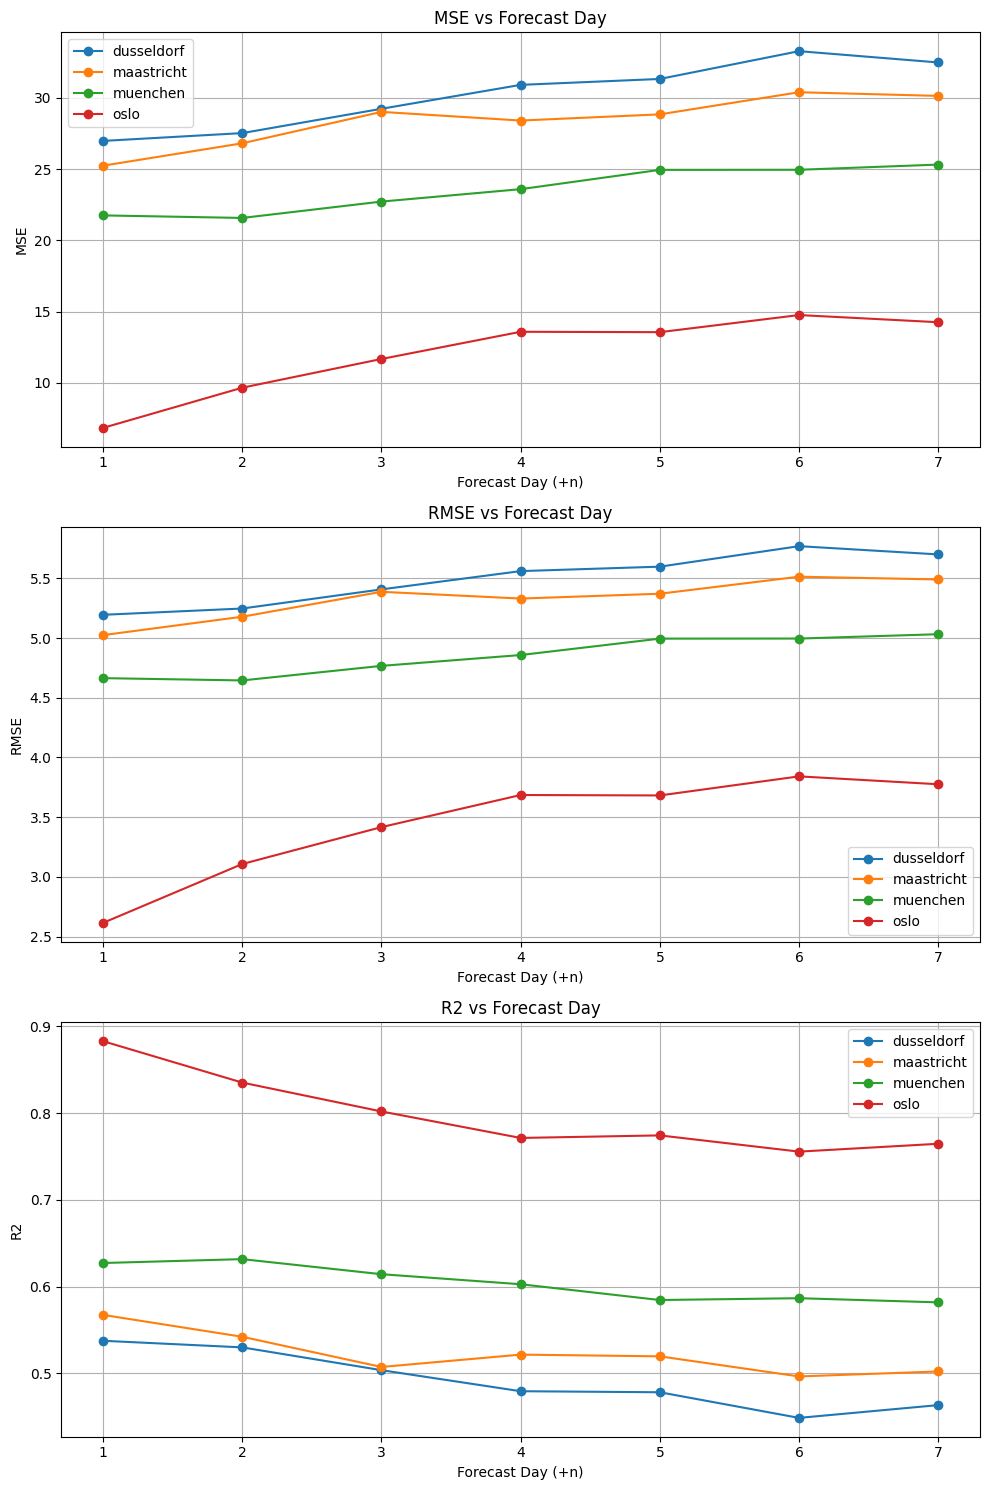

In [ ]:
results = []

for (kota, day_ahead), (test_idx, y_pred) in predictions.items():
    X = df_kota[feature_cols]
    y_true = df_kota[f'tempmean_day{day_ahead}'].iloc[test_idx]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    results.append({
        'city': kota,
        'day_ahead': day_ahead,
        'mse': mse,
        'rmse': rmse,
        'r2': r2
    })

results_df = pd.DataFrame(results)

cities = results_df['city'].unique()
metrics = ['mse', 'rmse', 'r2']

fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 15))

for i, metric in enumerate(metrics):
    ax = axs[i]
    for city in cities:
        data = results_df[results_df['city'] == city]
        ax.plot(data['day_ahead'], data[metric], marker='o', label=city)
    ax.set_title(f'{metric.upper()} vs Forecast Day')
    ax.set_xlabel('Forecast Day (+n)')
    ax.set_ylabel(metric.upper())
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


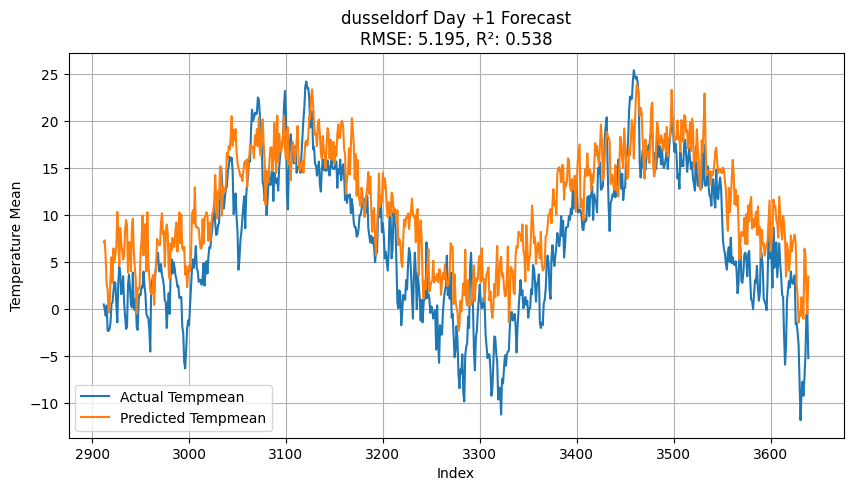

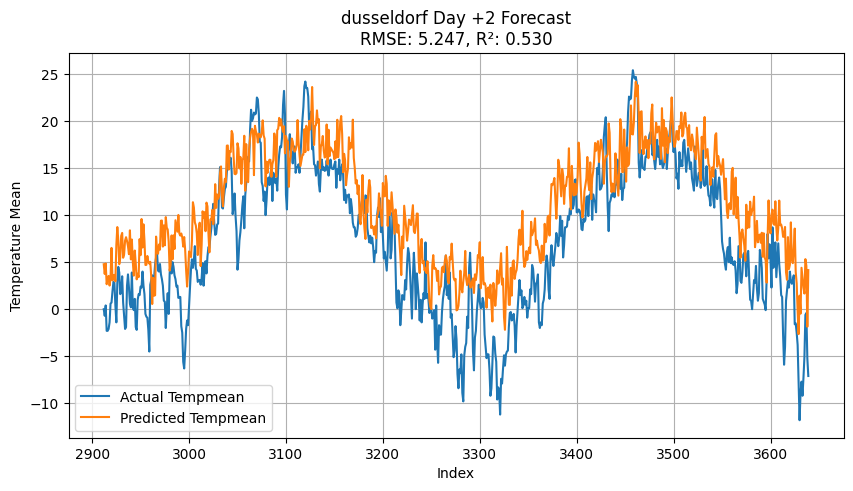

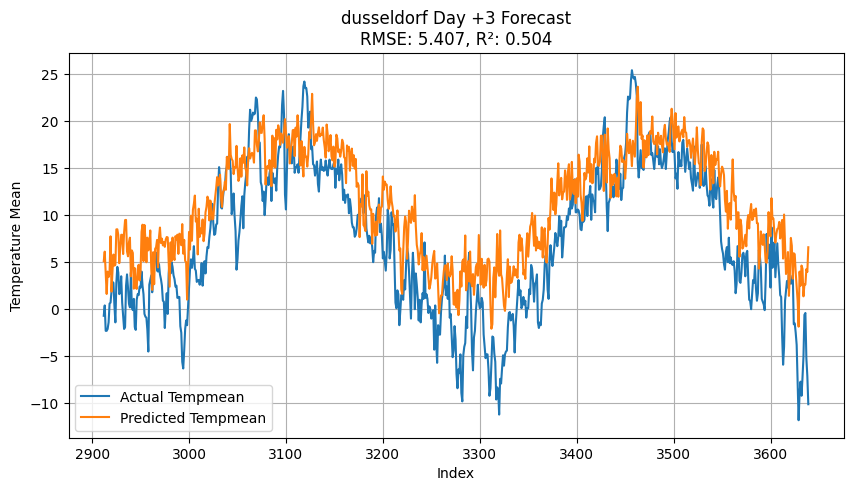

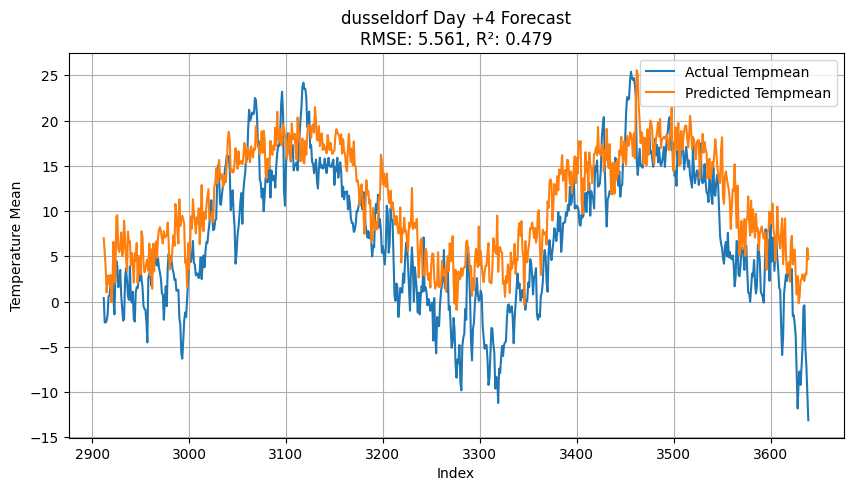

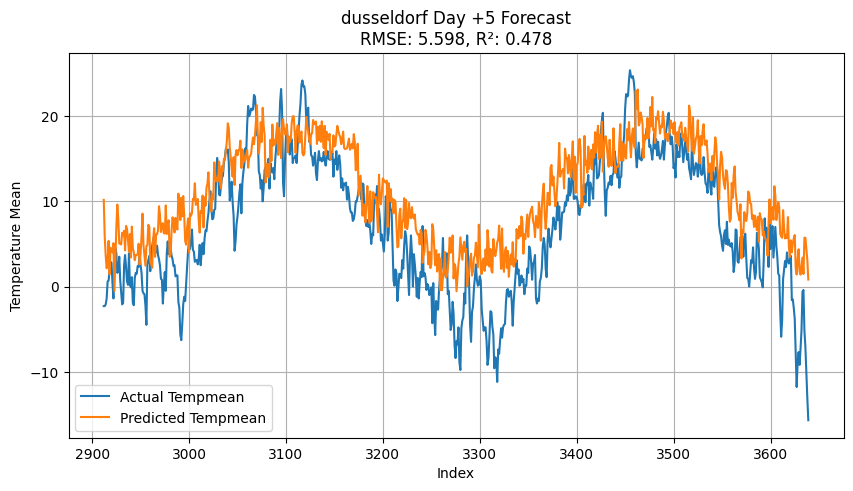

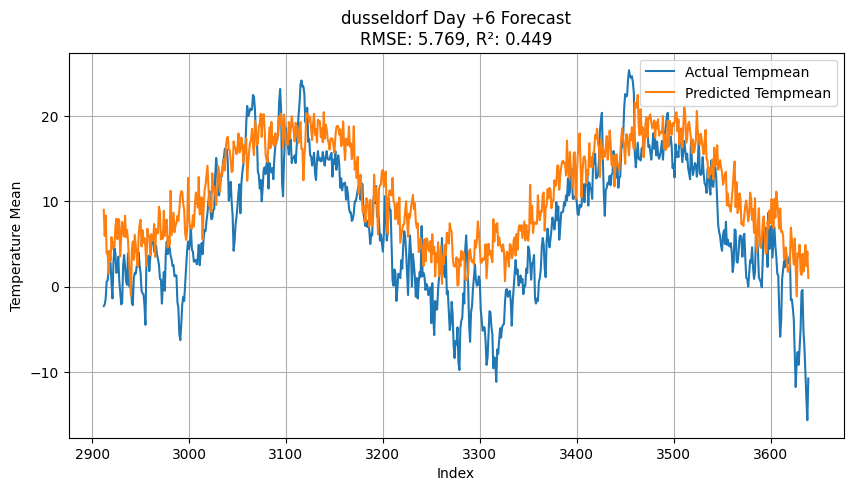

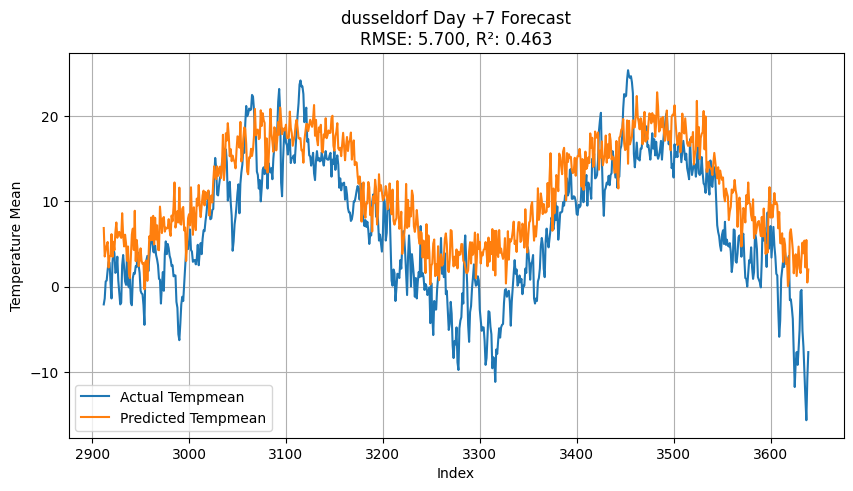

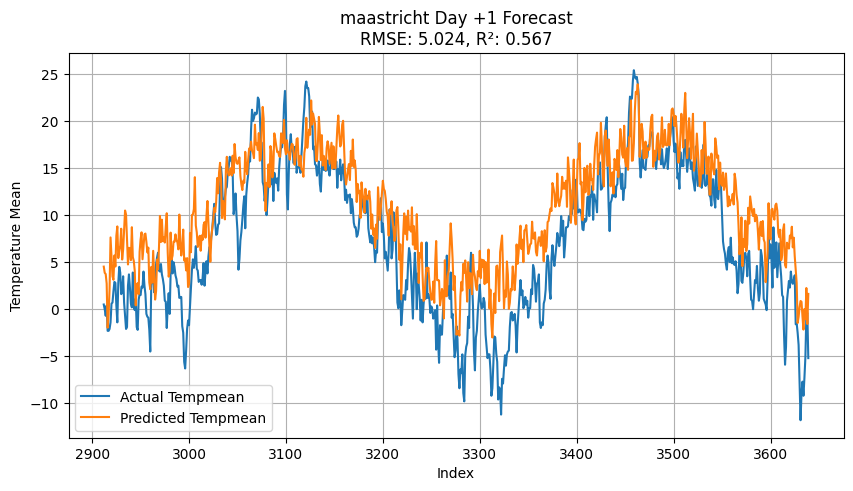

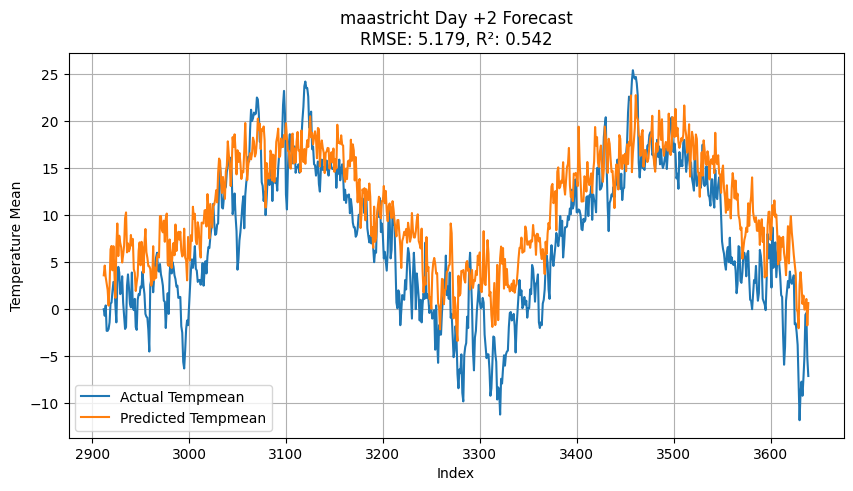

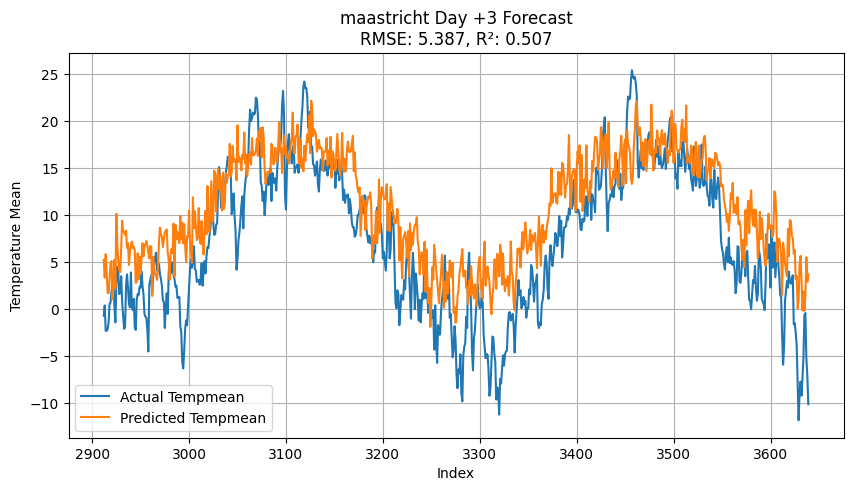

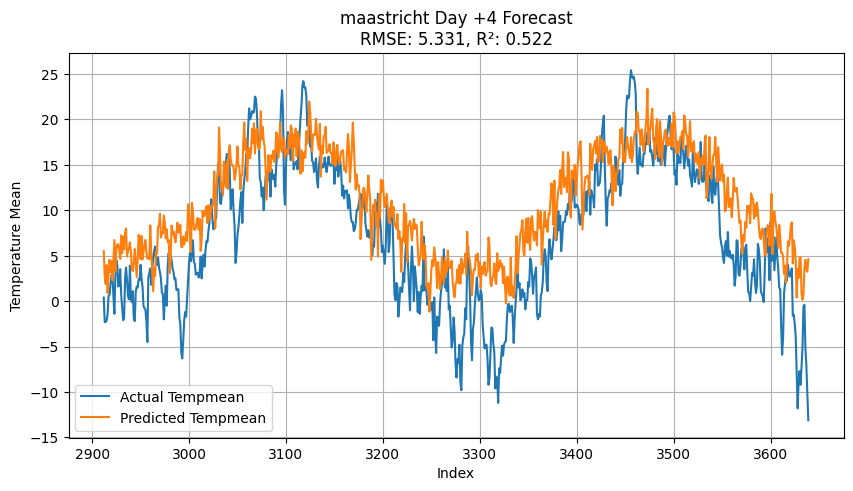

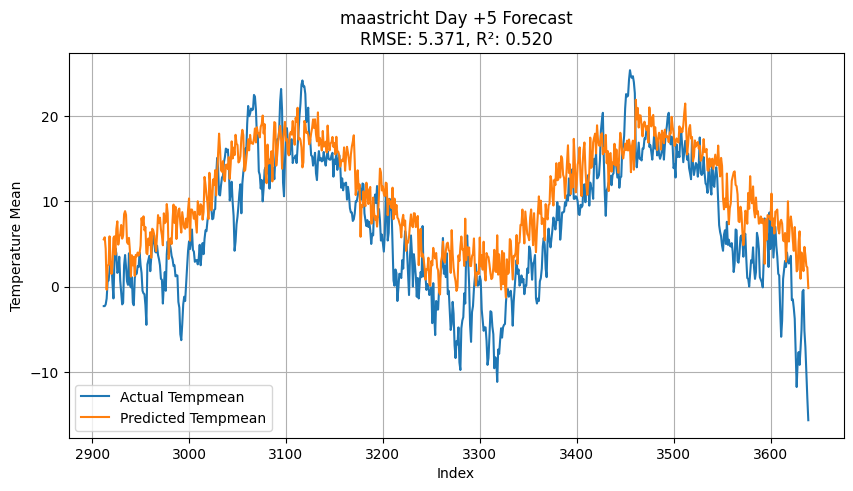

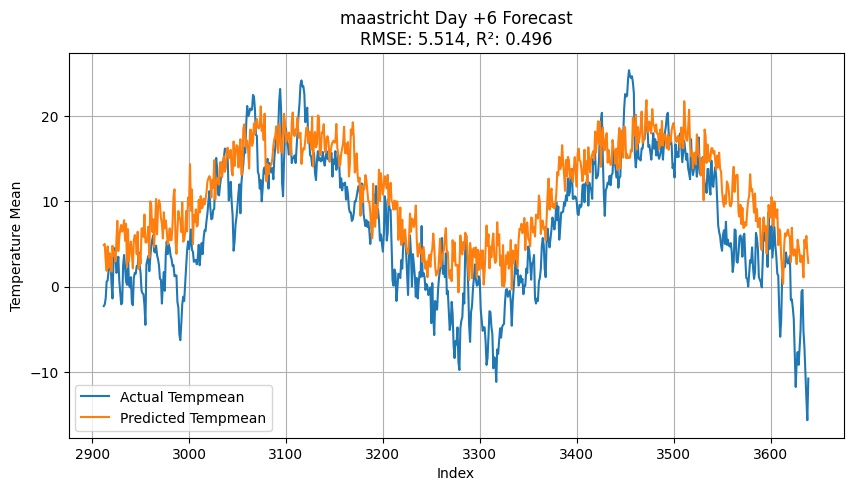

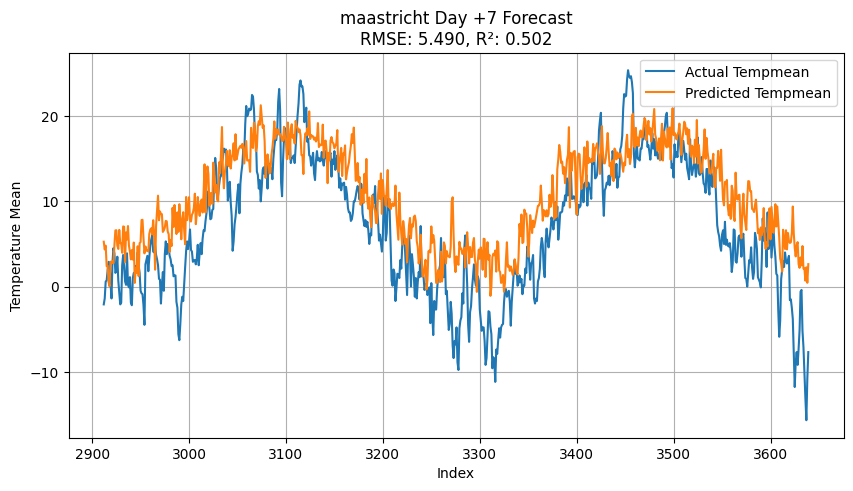

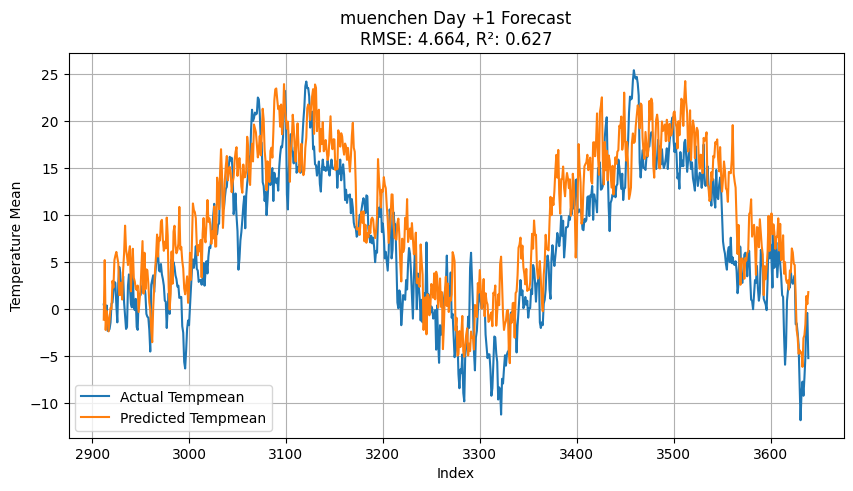

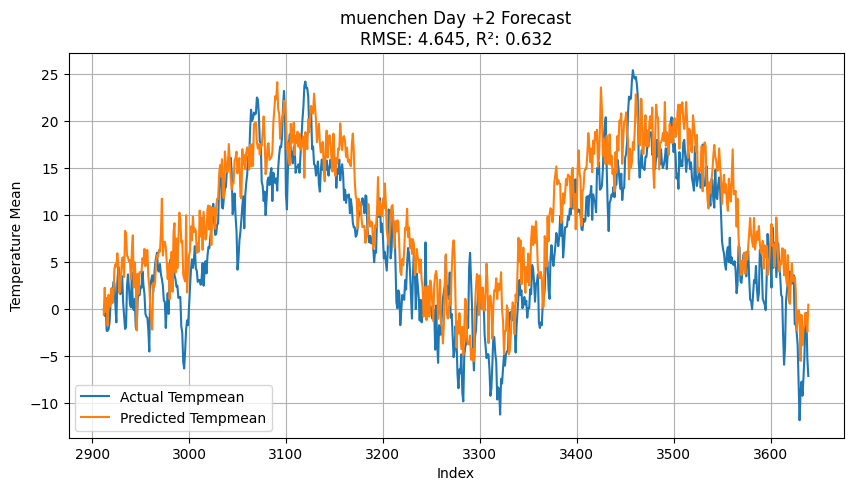

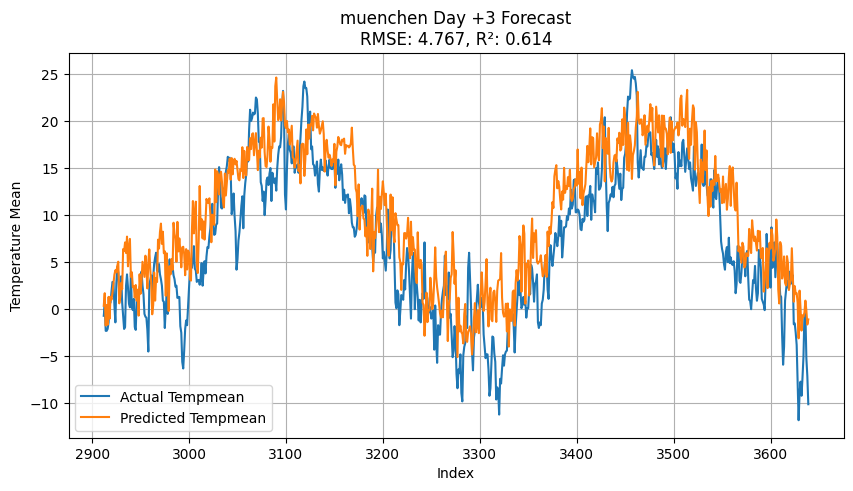

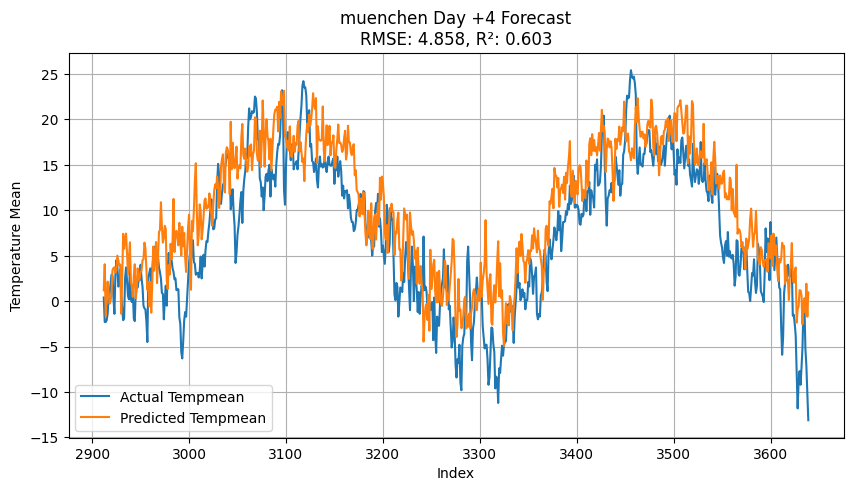

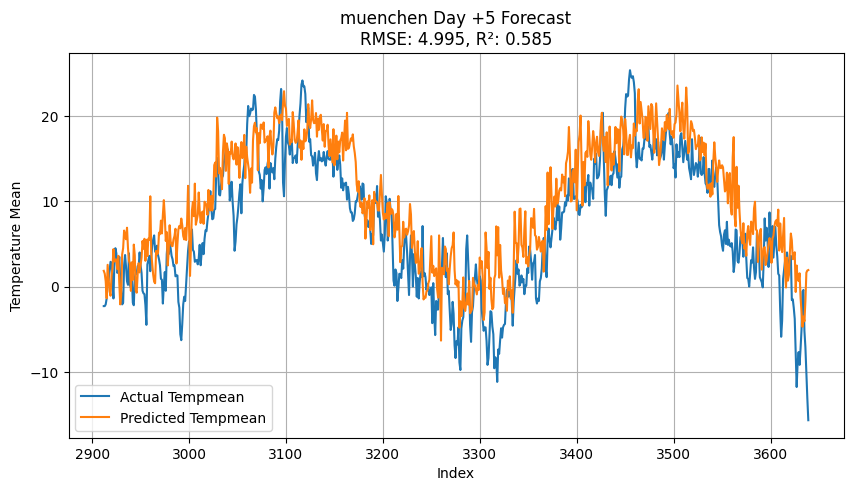

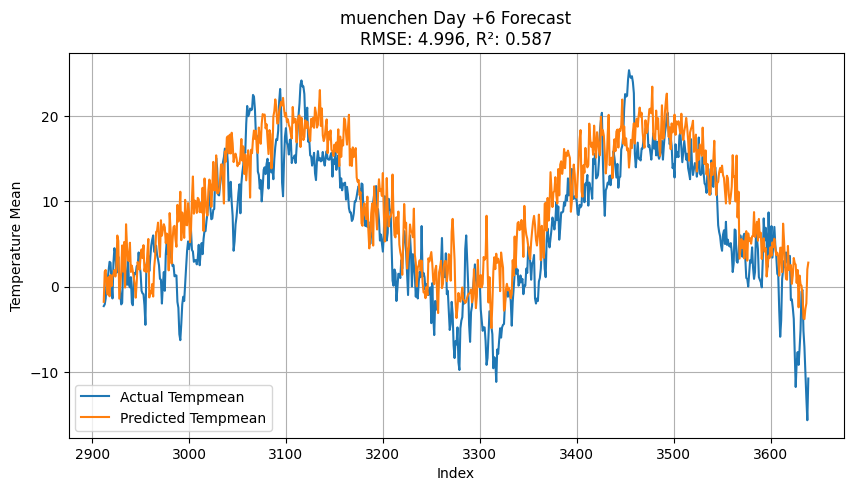

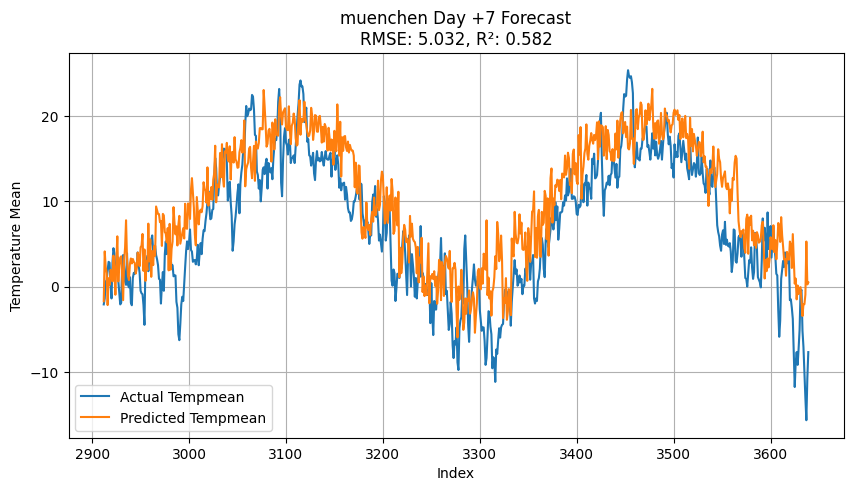

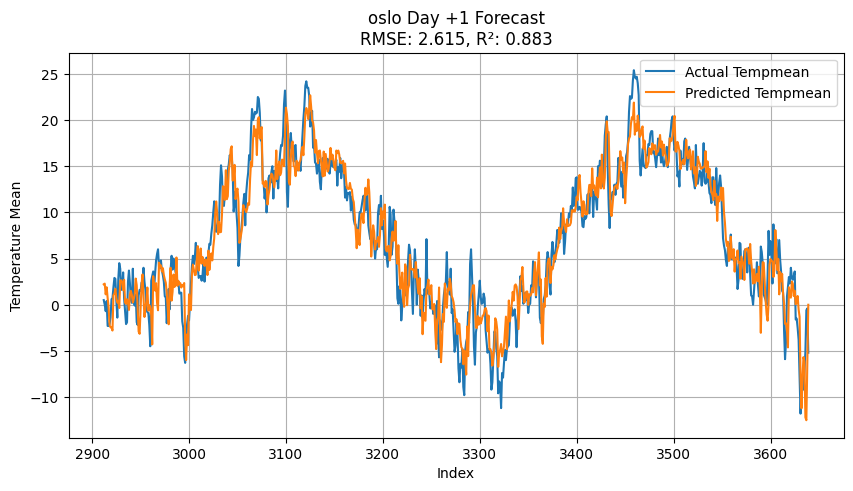

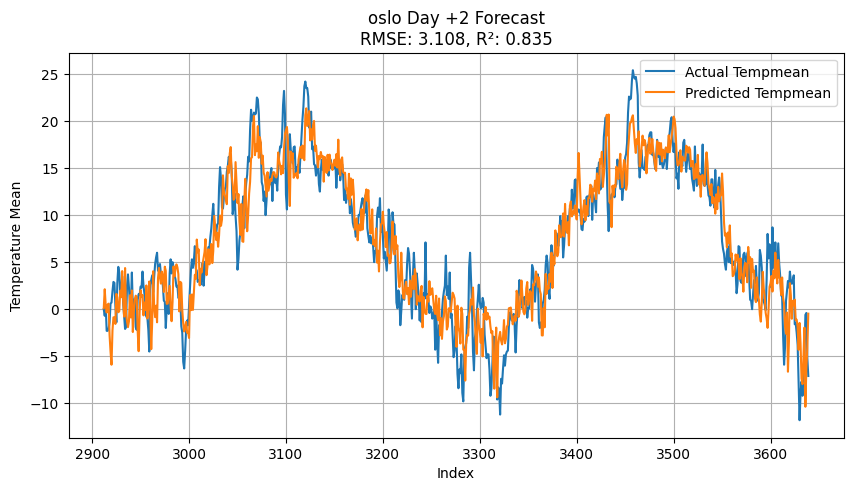

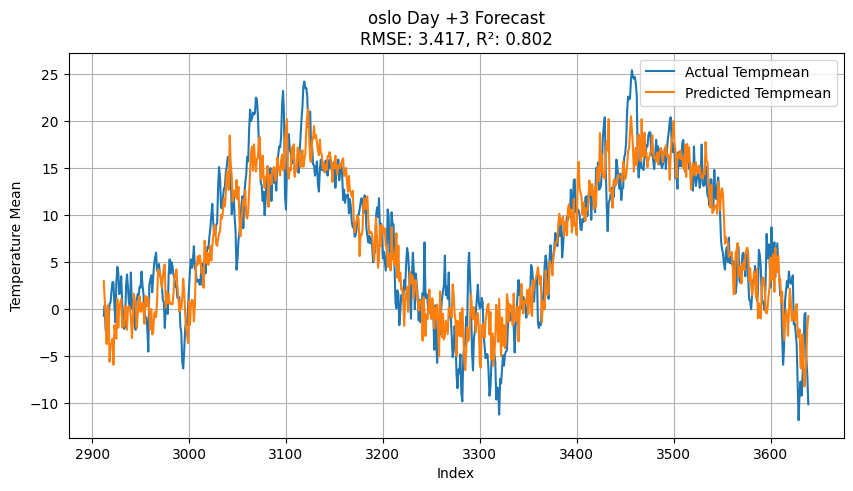

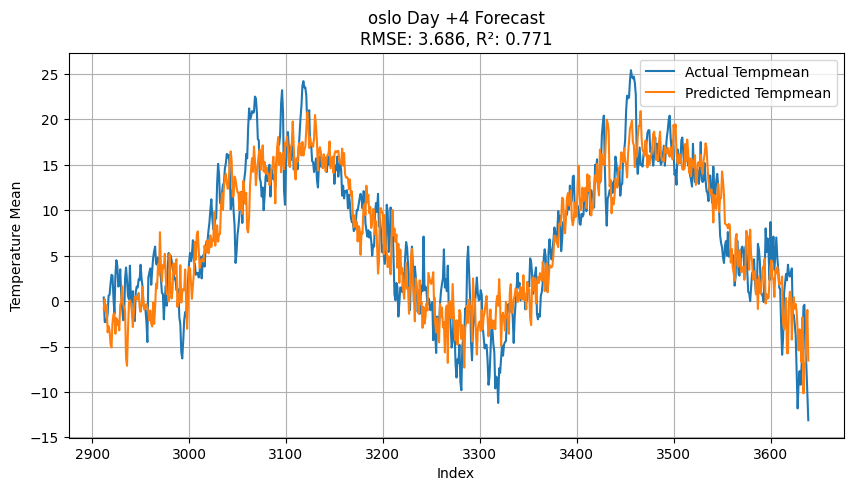

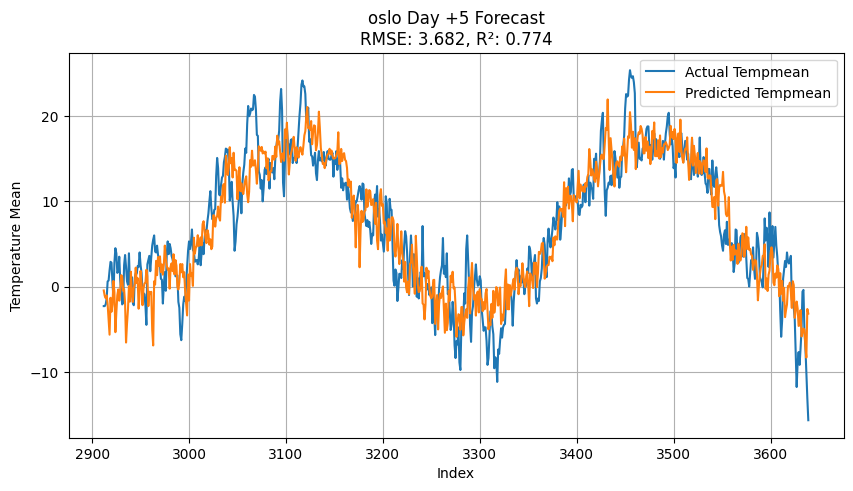

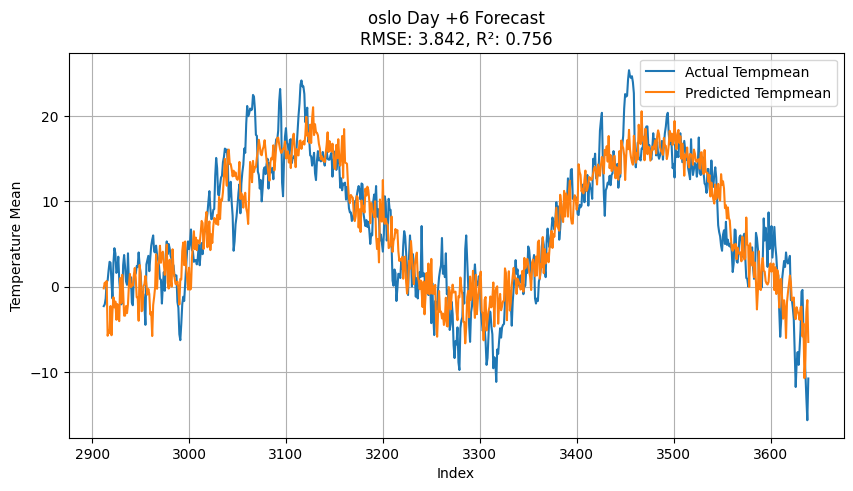

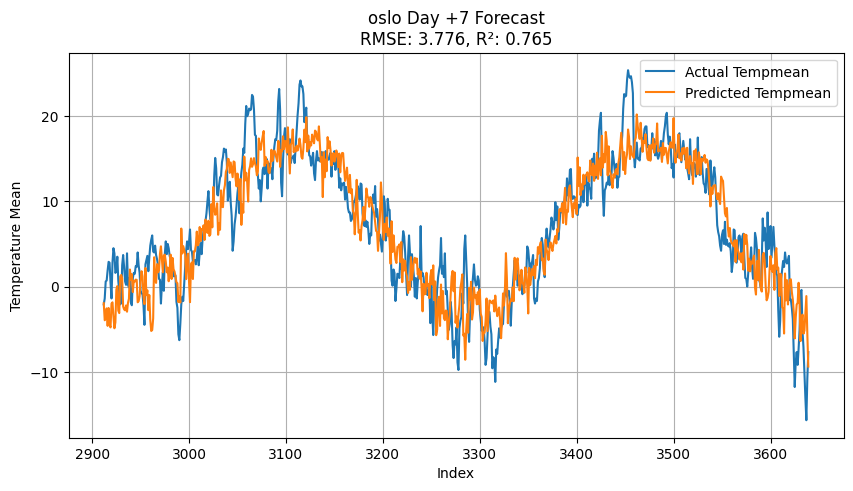

In [ ]:
def plot_forecast(city, day_ahead, idx, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    plt.figure(figsize=(10,5))
    plt.plot(idx, y_true, label='Actual Tempmean')
    plt.plot(idx, y_pred, label='Predicted Tempmean')
    plt.title(f'{city} Day +{day_ahead} Forecast\nRMSE: {rmse:.3f}, R²: {r2:.3f}')
    plt.xlabel('Index')
    plt.ylabel('Temperature Mean')
    plt.legend()
    plt.grid(True)
    plt.show()

for kota in kota_list:
    for day_ahead in range(1, 8):
        idx, y_pred = predictions[(kota, day_ahead)]
        y_test = df_kota.loc[idx, f'tempmean_day{day_ahead}']
        plot_forecast(kota, day_ahead, idx, y_test, y_pred)
